In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=1.0)
X.info()

< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found


/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:251: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456435 entries, 0 to 456434
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             456435 non-null  int64  
 1   in_channels   456435 non-null  int64  
 2   iH            456435 non-null  int64  
 3   iW            456435 non-null  int64  
 4   out_channels  456435 non-null  int64  
 5   groups        456435 non-null  int64  
 6   kH            456435 non-null  int64  
 7   kW            456435 non-null  int64  
 8   stride        456435 non-null  int64  
 9   dilation      456435 non-null  int64  
 10  gflops        456435 non-null  float64
 11  dtype_16      456435 non-null  bool   
 12  dtype_32      456435 non-null  bool   
 13  dtype_b16     456435 non-null  bool   
 14  transposed_0  456435 non-null  bool   
 15  transposed_1  456435 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 40.5 MB


In [3]:
df = pd.concat([X, y], axis=1)
df = df.query("time > 0").dropna()
X, y = df.drop(["time"], axis=1), df["time"]

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318339 entries, 267849 to 121958
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             318339 non-null  int64  
 1   in_channels   318339 non-null  int64  
 2   iH            318339 non-null  int64  
 3   iW            318339 non-null  int64  
 4   out_channels  318339 non-null  int64  
 5   groups        318339 non-null  int64  
 6   kH            318339 non-null  int64  
 7   kW            318339 non-null  int64  
 8   stride        318339 non-null  int64  
 9   dilation      318339 non-null  int64  
 10  gflops        318339 non-null  float64
 11  dtype_16      318339 non-null  bool   
 12  dtype_32      318339 non-null  bool   
 13  dtype_b16     318339 non-null  bool   
 14  transposed_0  318339 non-null  bool   
 15  transposed_1  318339 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 30.7 MB


# Fitting

## Decision Tree

Train--------
Mean Squared Error: 7961.719208911953
MAPE: 0.0401041135310573
R-squared: 0.9741479689846194


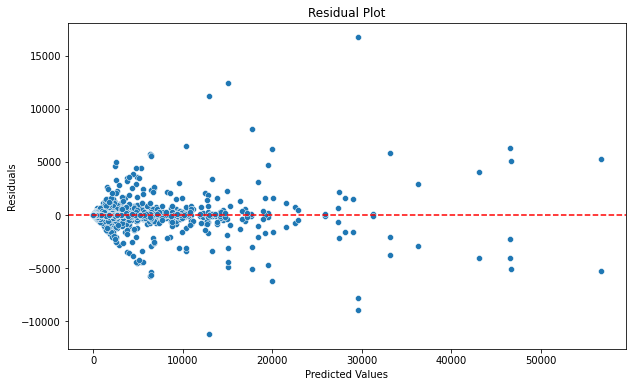

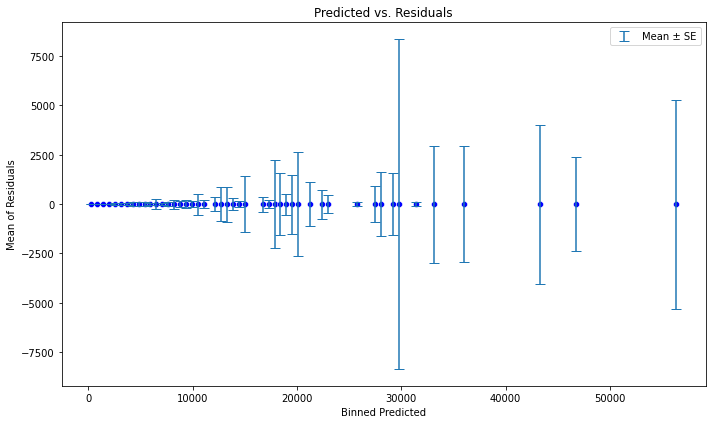

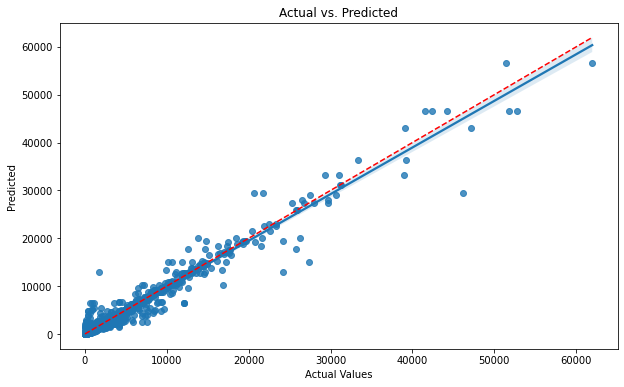

Val--------
Mean Squared Error: 75064.79841147416
MAPE: 0.12514685024631794
R-squared: 0.7153331025971379


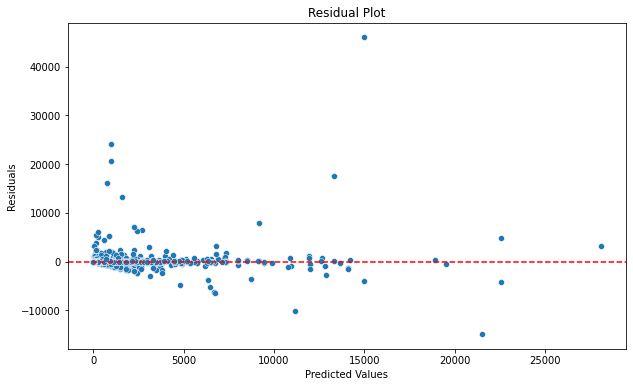

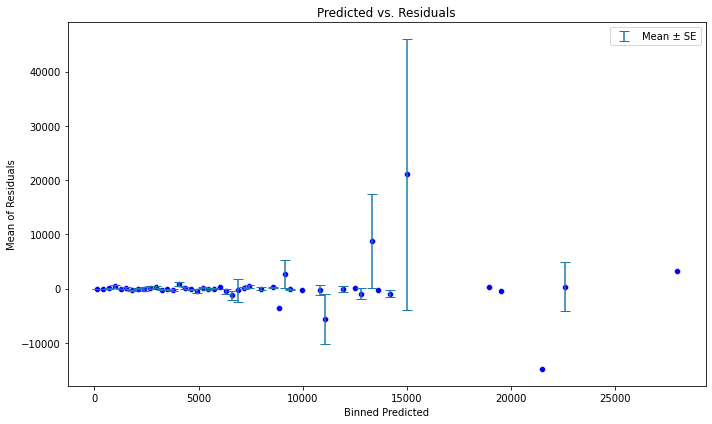

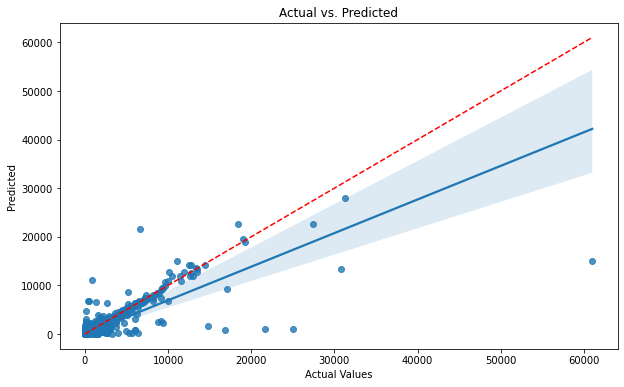

In [5]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [6]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

         Feature  Importance
10        gflops    0.355162
5         groups    0.266533
1    in_channels    0.105506
0              b    0.066174
6             kH    0.050858
11      dtype_16    0.037919
7             kW    0.037557
12      dtype_32    0.034210
4   out_channels    0.023404
3             iW    0.009066
2             iH    0.006684
13     dtype_b16    0.003202
14  transposed_0    0.002519
15  transposed_1    0.001206
8         stride    0.000000
9       dilation    0.000000


## Random Forest

In [7]:
tree_model = RandomForestRegressor(n_estimators=30, max_depth=25, random_state=random_seed)
tree_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=30, random_state=42)

Train--------
Mean Squared Error: 6446.961094763684
MAPE: 0.07423210454158871
R-squared: 0.9790664511265075


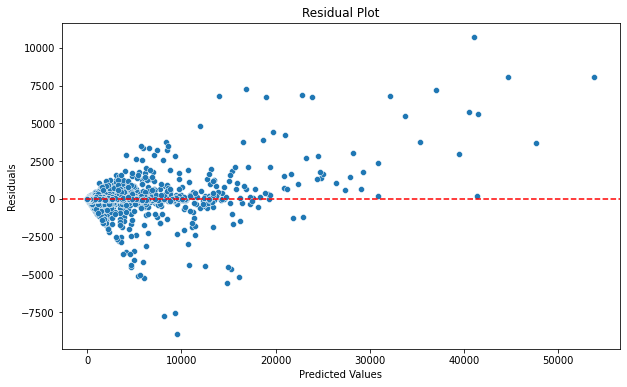

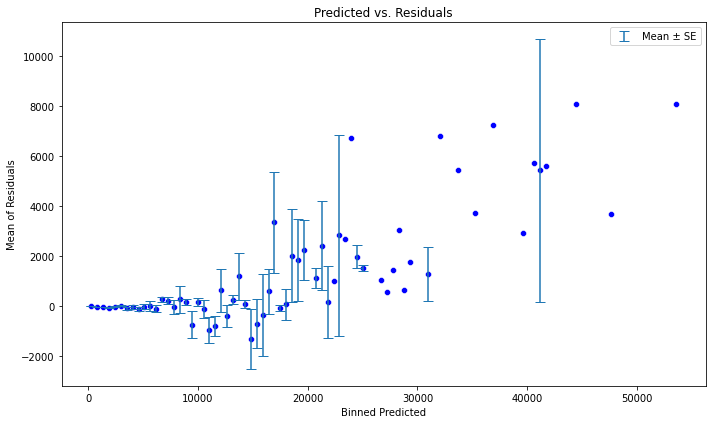

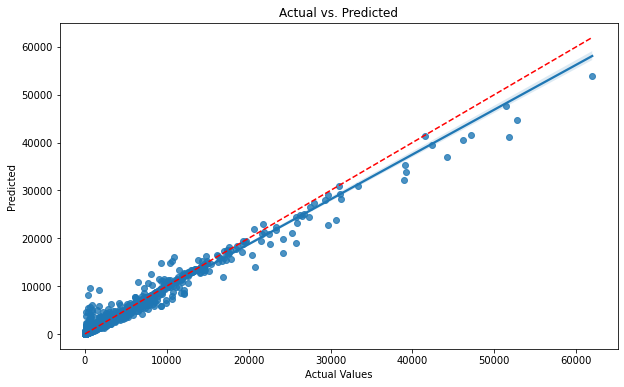

Val--------
Mean Squared Error: 42028.67866325535
MAPE: 0.14915866958730298
R-squared: 0.8406153908330224


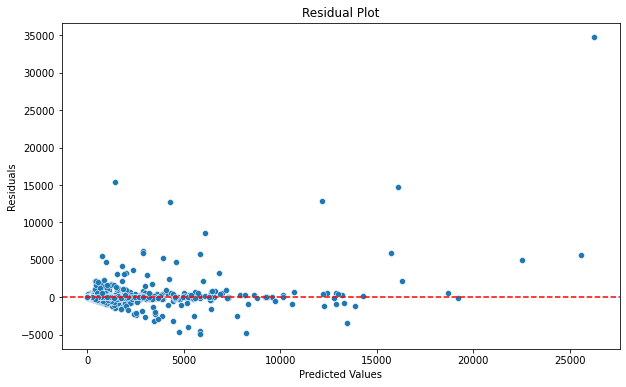

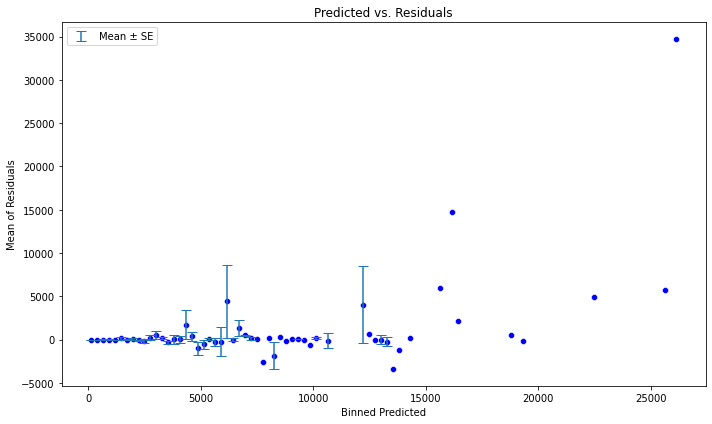

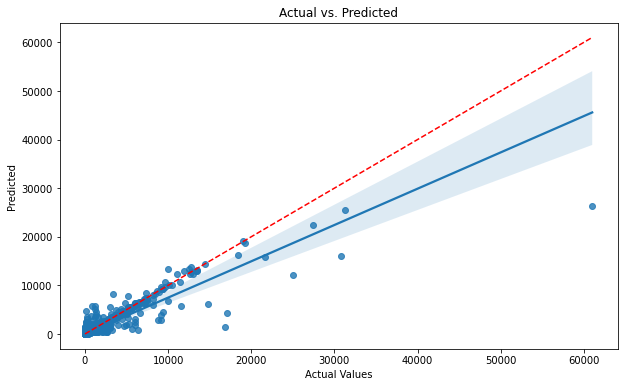

In [8]:
y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [9]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

features_df = features_df.sort_values(by="Importance", ascending=False)
features_df

,Feature,Importance
10,gflops,0.367609
5,groups,0.256913
1,in_channels,0.063068
0,b,0.058073
11,dtype_16,0.055649
4,out_channels,0.054074
12,dtype_32,0.036571
6,kH,0.035124
7,kW,0.032489
3,iW,0.018084


# What's up with the underpredicted large values?

Might be throttling.

In [10]:
df.query("time > 30000")

,b,in_channels,iH,iW,out_channels,groups,kH,kW,stride,dilation,gflops,dtype_16,dtype_32,dtype_b16,transposed_0,transposed_1,time
342133,32,3072,128,1024,3072,1024,7,5,1,1,2.770769e+06,True,False,False,False,True,31279.931641
343569,32,3072,128,1024,3072,1024,3,5,1,1,1.187473e+06,True,False,False,False,True,42441.984375
343627,32,3072,128,1024,3072,1024,5,3,1,1,1.187473e+06,True,False,False,False,True,47111.929688
345213,32,3072,128,1024,3072,1024,7,3,1,1,1.662462e+06,True,False,False,False,True,61956.699219
345370,32,2048,128,1024,2048,1024,7,3,1,1,7.388718e+05,True,False,False,False,True,30083.922852
345889,32,3072,128,1024,3072,1024,7,7,1,1,3.879077e+06,True,False,False,False,True,39196.076172
346249,32,3072,128,1024,3072,512,5,3,1,1,1.187473e+06,True,False,False,False,True,31108.275391
347205,32,3072,128,1024,3072,512,7,3,1,1,1.662462e+06,True,False,False,False,True,31308.554688
348185,32,3072,128,1024,3072,1024,3,7,1,1,1.662462e+06,True,False,False,False,True,52762.773438
411346,32,1536,512,512,1536,256,7,3,1,1,8.312308e+05,True,False,False,False,True,30828.345703


# GridsearchCV

In [10]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

param_grid = {
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [2, 10, 20],
    "max_features": [50, 100, 1.0, "sqrt"],
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring=make_scorer(r2_score),
    cv=5,
    # verbose=2,
    n_jobs=-1,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  0.6870819071569367


In [11]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9982.444637877275
MAPE: 0.23103490969705714
R-squared: 0.9645004139536991


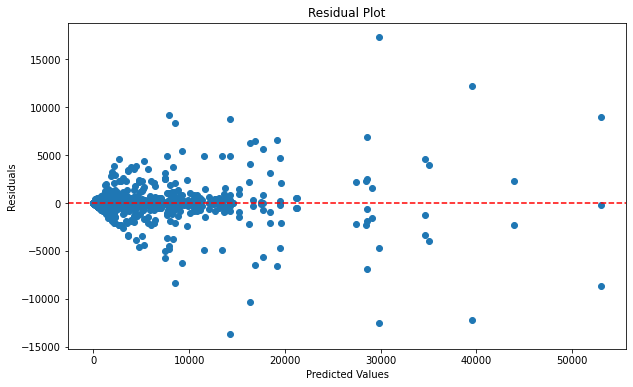

Val--------
Mean Squared Error: 38646.79429864945
MAPE: 0.282881790979092
R-squared: 0.8377715080308532


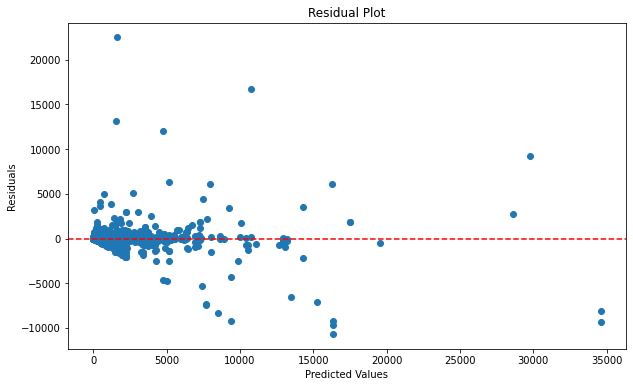

In [12]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)

In [13]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 1.0, 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),  # Use R-squared as the performance metric
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 40, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -0.1586529198468168


In [14]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=40, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9981.278646099066
MAPE: 0.0405494762183794
R-squared: 0.9645045604555793


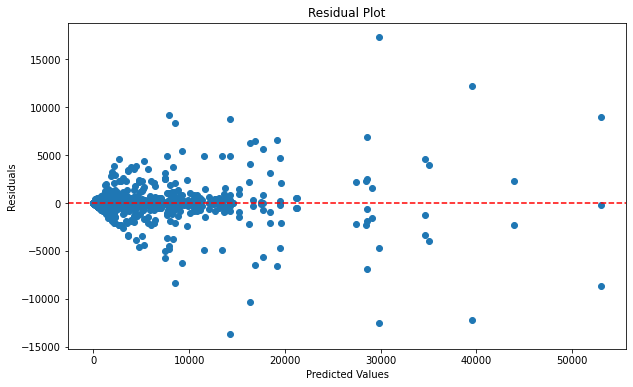

Val--------
Mean Squared Error: 38808.70579884653
MAPE: 0.13223612595628043
R-squared: 0.8370918485924415


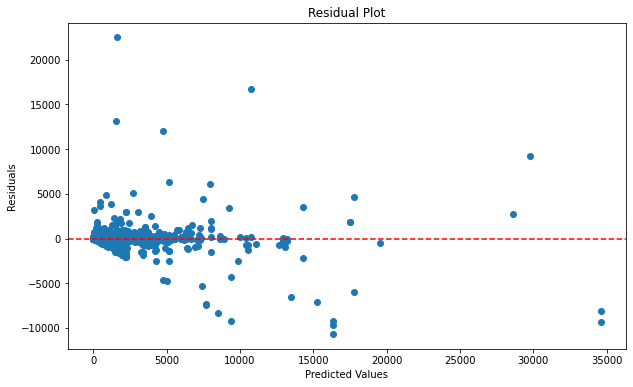

In [15]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [16]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 1.0, 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -84025.7469057844


In [17]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 9982.444637877275
MAPE: 0.23103490969705714
R-squared: 0.9645004139536991


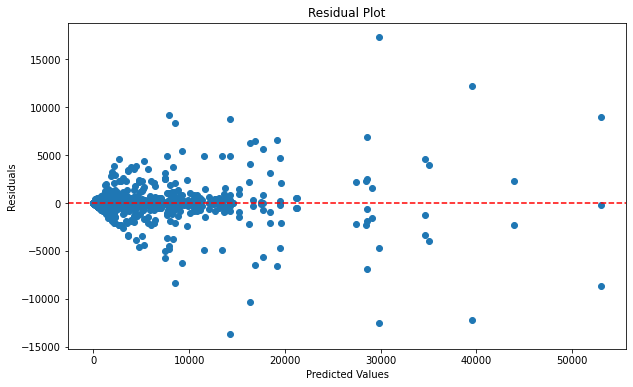

Val--------
Mean Squared Error: 38646.79429864945
MAPE: 0.282881790979092
R-squared: 0.8377715080308532


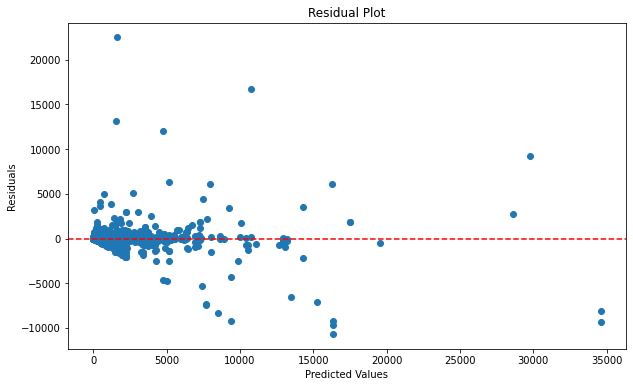

In [18]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)